In [1]:
from scipy.io import loadmat, savemat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style
import tensorflow as tf
print('Tensorflow version', tf.__version__)

%matplotlib inline
matplotlib.style.use("ggplot")

Tensorflow version 1.1.0


<ol>
<li><a href="#Loading-and-Formatting-Data">Loading and Formatting Data</a></li>
<li><a href="#Defining-Helper-Functions">Defining Helper Functions</a></li>
<li><a href="#Test-Model">Test Model</a></li>
</ol>

# Loading and Formatting Data

In [3]:
synth_data = loadmat('./fabricated_mnist_data/data_and_labels.mat')
all_x = synth_data['data']
all_y = synth_data['labels']
print("X shape", all_x.shape)
print("Y 'shape'", all_y.shape)
print("Y first example shape", all_y[0, 0].shape)
print("Y last example shape", all_y[0, -1].shape)

X shape (23330, 28, 140)
Y 'shape' (1, 23330)
Y first example shape (1, 10)
Y last example shape (5, 10)


Reshape y by padding < 5 length labels, and getting the length of the labels

In [4]:
all_y = all_y.reshape(-1)
all_y_lens = np.array([len(y_ex) for y_ex in all_y])
def pad(y_ex):
    toreturn = np.zeros((5, 10))
    toreturn[:len(y_ex), :] = y_ex
    return toreturn
pad(np.arange(10*2).reshape(2, 10))


array([[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
       [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

In [5]:
all_y = np.array([pad(y_ex) for y_ex in all_y])
all_y.shape

(23330, 5, 10)

One-hot encode the lengths of the sequences

In [6]:
def one_hot(num):
    num = np.ravel(num).astype(int)
    toreturn = np.zeros(shape=(len(num), 5), dtype=np.int16)
    for i, dig in enumerate(num):
        toreturn[i, dig-1] = 1
    return toreturn    
all_y_lens = one_hot(all_y_lens)

Define train-test-validation split and reshape the data to explicitly have channel size 1

In [7]:
all_x.shape

(23330, 28, 140)

In [8]:
np.random.seed(999)
idx = np.arange(len(all_x))
np.random.shuffle(idx)
temp = len(all_x)//5

train_idx = idx[:(temp*3)]
valid_idx = idx[(temp*3):(temp*4)]
test_idx = idx[(temp*4):]

train_x = all_x[train_idx].reshape(-1, 28, 140, 1)
train_y = all_y[train_idx]
train_ylen = all_y_lens[train_idx]

valid_x = all_x[valid_idx].reshape(-1, 28, 140, 1)
valid_y = all_y[valid_idx]
valid_ylen = all_y_lens[valid_idx]

test_x = all_x[test_idx].reshape(-1, 28, 140, 1)
test_y = all_y[test_idx]
test_ylen = all_y_lens[test_idx]

# Defining Helper Functions

In [9]:
def masked_xe(output, target):
    """Compute the average cross entropy of sequences up to the lengths of the targets.
    
    This assumes a target is of shape [N, L, K], where N is the number of examples, L is the maximum 
    sequence length, and K is the number of classes. Additionally, target should be zero-padded to
    arrive at the max sequence length for all sequences
    
    Borrowed from https://danijar.com/variable-sequence-lengths-in-tensorflow/.
    """
    
    cross_entropy = target * tf.log(output)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)
    mask = tf.sign(tf.reduce_max(tf.abs(target), reduction_indices=2))
    cross_entropy *= mask
    
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    cross_entropy /= tf.reduce_sum(mask, reduction_indices=1)
    return tf.reduce_mean(cross_entropy)

In [10]:
def get_pred(len_proba, dig_proba):
    
    length = np.argmax(len_proba, axis=-1)
    digits = np.argmax(dig_proba, axis=-1)
    
    return [''.join([str(x) for x in dig[:ilen+1]]) for ilen, dig in zip(length, digits)]
lens = [
    [0, 1]+[0]*3
]
digs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]
get_pred(lens, digs)

['12']

In [11]:
lens = [
    [0, 1]+[0]*3,
    [0, 0, 0, 1]+[0]
]
digs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ],
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]

In [12]:
plens = [
    [0, 1]+[0]*3,
    [0, 0, 1]+[0]*2
]
pdigs = [
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ],
    [
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
        [0, 1]+[0]*8,
        [0, 0.2, 0.8] + [0]*7,
    ]
]

In [13]:
get_pred(lens, digs)

['12', '1212']

In [14]:
get_pred(plens, pdigs)

['12', '121']

In [15]:
def c(a):
    if isinstance(a, tf.Tensor):
        return a.eval()
    else:
        return a

In [16]:
def accuracy(y_true, y_len_true, y_pred, y_len_pred):
    y_true = c(y_true)
    y_len_true = c(y_len_true)
    y_pred = c(y_pred)
    y_len_pred = c(y_len_pred)
    actual = np.array(get_pred(y_len_true, y_true))
    pred = np.array(get_pred(y_len_pred, y_pred))
    return np.mean(actual == pred)
accuracy(digs, lens, pdigs, plens)

0.5

# Test Model

In [16]:
lr = 0.001
len_balance = 0.8  # give the sequence length loss len_balance weight and the sequence digits loss (1-len_balance) weight 
simplest_graph =  tf.Graph()

In [17]:
with simplest_graph.as_default(): 
    tf_x = tf.placeholder(tf.float32, (None, all_x.shape[1], all_x.shape[2], 1))
    tf_y = tf.placeholder(tf.float32, (None, all_y.shape[1], all_y.shape[2]))
    tf_ylen = tf.placeholder(tf.int32, (None, 5))
    
    # (N, 28, 140, 1)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 5], stddev=0.1, seed=54), name="conv1_w")
    conv1_b = tf.Variable(tf.zeros(shape=[5]), name="conv1_b")
    
    # (N, 28, 140, 5)
    conv2_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 5, 5], stddev=0.1, seed=741), name="conv2_w")
    conv2_b = tf.Variable(tf.zeros(shape=[5]), name="conv2_b")
    
    # (N, 28, 140, 5)
    
    
    # (N, 15, 71, 5)
    conv4_w = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 15], stddev=0.1, seed=11), name="conv4_w")
    conv4_b = tf.Variable(tf.zeros(shape=[15]), name="conv4_b")
    
    # (N, 15, 71, 15)
    conv5_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 15, 7], stddev=0.1, seed=11), name="conv5_w")
    conv5_b = tf.Variable(tf.zeros(shape=[7]), name="conv5_b")
    
    # (N, 15, 71, 7)
        
    # (N, 8, 36, 7)
    conv7_w = tf.Variable(tf.truncated_normal(shape=[2, 4, 7, 4], stddev=0.1, seed=11), name="conv7_w")
    conv7_b = tf.Variable(tf.zeros(shape=[4]), name="conv7_b")
    
    
    # (N, 8, 36, 4) -> (N, 1410)
    dens8_w = tf.Variable(tf.truncated_normal(shape=[980, 400], stddev=0.1, seed=65), name="dens8_w")
    dens8_b = tf.Variable(tf.zeros(shape=[400]), name="dens8_b")
    
    # (N, 200)
    len_w = tf.Variable(tf.truncated_normal(shape=[400, 5], stddev=0.1, seed=76), name="len_w")
    len_b = tf.Variable(tf.zeros(shape=[5]), name="len_b")
    
    # (N, 200)
    dig_w = tf.Variable(tf.truncated_normal(shape=[400, 5*10], stddev=0.1, seed=87), name="dig_w")
    dig_b = tf.Variable(tf.zeros(shape=[5*10]), name="dig_b")

In [18]:
def model(x):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    return o8

In [19]:
with simplest_graph.as_default():
    
    hrep = model(tf_x)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
#     tf_dig_loss = tf.reduce_mean(
#         tf.nn.softmax_cross_entropy_with_logits(
#             labels=tf.boolean_mask(tf_y, mask),
#             logits=tf.boolean_mask(tf_diglogit, mask)
#         )
#     )
    
    
    cross_entropy = -tf.reduce_sum(tf_y * tf.log(tf_digproba), reduction_indices=2)
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    masked_cross_entropy = cross_entropy * mask
    
    mean_masked_xe = tf.reduce_sum(masked_cross_entropy, reduction_indices=1)
    mean_masked_xe /= tf.reduce_sum(mask, reduction_indices=1)

    tf_dig_loss = tf.reduce_mean(masked_xe(tf_digproba, tf_y))
    
    
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance))

In [20]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 2500
compare_every = 30
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [21]:
def capture_performance():
    global session
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global train_ylen
    global valid_x
    global valid_y
    global valid_ylen
    global t_acc
    global v_acc
#     print('Saving performance')
    
    train_len_loss, train_dig_loss, train_len_proba, train_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_y: train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_ylen: train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)]        
    })
    
    valid_len_loss, valid_dig_loss, valid_len_proba, valid_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    
    t_len_losses.append(np.mean(train_len_loss))
    t_dig_losses.append(np.mean(train_dig_loss))
    t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                          train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)],
                          train_dig_proba,
                          train_len_proba))
    v_len_losses.append(np.mean(valid_len_loss))
    v_dig_losses.append(np.mean(valid_dig_loss))
    v_acc.append(accuracy(valid_y, valid_ylen, valid_dig_proba, valid_len_proba))                      

C:\Users\Ian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Epoch 0
Validation accuracy 41.899%
Mean batch len loss 0.043
Valid len loss 0.012
Mean batch dig loss 1.420
Valid dig loss 0.804


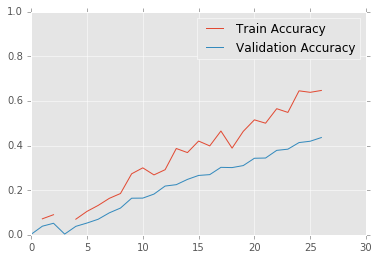

Epoch 1
Validation accuracy 60.544%
Mean batch len loss 0.006
Valid len loss 0.012
Mean batch dig loss 0.537
Valid dig loss 0.479


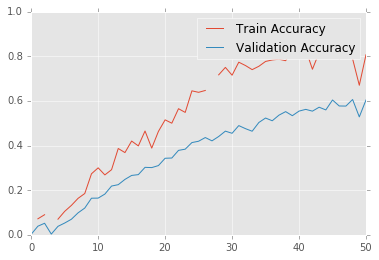

Epoch 2
Validation accuracy 66.417%
Mean batch len loss 0.004
Valid len loss 0.009
Mean batch dig loss 0.305
Valid dig loss 0.386


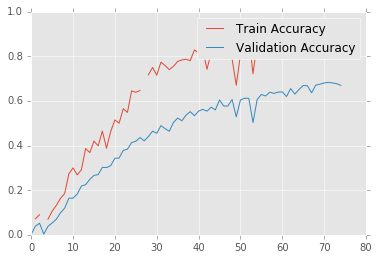

Epoch 3
Validation accuracy 71.753%
Mean batch len loss 0.000
Valid len loss 0.006
Mean batch dig loss 0.189
Valid dig loss 0.340


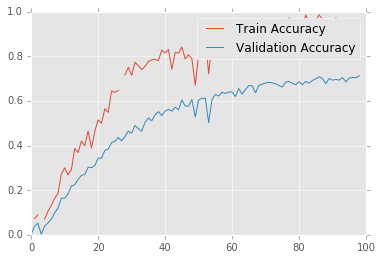

KeyboardInterrupt: 

In [23]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='best')
    plt.show()

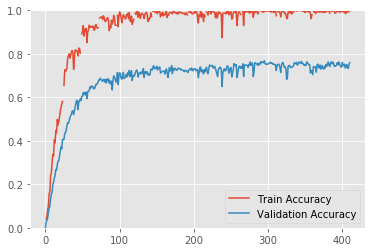

In [213]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend()
plt.show()

## Adding some regularization

Trying a different weight between length and digit prediction, 0.75 dropout on dense layer along with weight decay

In [ ]:
len_balance = 0.5

In [ ]:
def model(x, p):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    
    o7resh = tf.reshape(o7, [-1, 980])
    o8 = tf.nn.relu(tf.matmul(o7resh, dens8_w) + dens8_b)
    o8 = tf.nn.dropout(o8, p)
    return o8

In [ ]:
with simplest_graph.as_default():
    p = tf.placeholder_with_default(1.0, shape=())
    hrep = model(tf_x, p)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
    var = tf.boolean_mask(tf_y, mask)
    tf_dig_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(
            labels=tf.boolean_mask(tf_y, mask),
            logits=tf.boolean_mask(tf_diglogit, mask)
        )
    )
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance) + 
                                 tf.nn.l2_loss(dens8_w)*0.003 + 
                                 tf.nn.l2_loss(len_w)*0.001 + 
                                 tf.nn.l2_loss(dig_w)*0.001)

In [ ]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [ ]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss, varval = session.run([updater, tf_len_loss, tf_dig_loss, var], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y,
                                                                    tf_ylen: batch_ylen, p: 0.75})
#         print(varval)
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

The same model but in keras (some small differneces like specifically using glorot uniform initializers

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPool2D, Reshape, Dropout, Masking, Activation
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras.activations import softmax
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

Using TensorFlow backend.


In [18]:
def tf_masked_xe(y_true, y_pred):

#     mask = tf.sign(tf.reduce_max(tf.abs(y_true), reduction_indices=2))
#     ndig = tf.reduce_sum(mask, axis=1)
# #     mask = tf.cast(mask, tf.bool)
# #     y_pred = tf.boolean_mask(y_pred / ndig, mask) 
# #     y_true = tf.boolean_mask(y_true, mask)  # degraded to [?, 10] shape, so we are evaluating the mean over all digits
#     cross_entropy = y_true * tf.log(y_pred)
#     cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=-1)
#     cross_entropy /= ndig
#     return tf.reduce_mean(cross_entropy)
    cross_entropy = y_true * tf.log(y_pred)
    cross_entropy = -tf.reduce_sum(cross_entropy, reduction_indices=2)  # definition
    mask = tf.sign(tf.reduce_max(tf.abs(y_true), reduction_indices=2))
#     cross_entropy *= mask
    
    cross_entropy = tf.reduce_sum(cross_entropy, reduction_indices=1)
    cross_entropy /= tf.reduce_sum(mask, reduction_indices=1)  # average across the sequence
    return tf.reduce_mean(cross_entropy)  # average across dataset

In [19]:
def acc(y_true, y_pred):
    return accuracy(y_true[1], y_true[0], y_pred[1], y_pred[0])

In [477]:
in0 = Input(shape=[all_x.shape[1], all_x.shape[2], 1], name='X')
conv1 = Conv2D(5, (3, 3), strides=(1, 1), padding='same', activation='relu')(in0)
conv2 = Conv2D(5, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv1)
max3 = MaxPool2D((2, 2), (2, 2), padding='same')(conv2)
conv4 = Conv2D(15, (3, 3), strides=(1, 1), padding='same', activation='relu')(max3)
conv5 = Conv2D(7, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv4)
max6 = MaxPool2D((2, 2), (2, 2), padding='same')(conv5)
conv7 = Conv2D(4, (2, 4), strides=(1, 1), padding='same', activation='relu')(max6)
resh7 = Reshape([980])(conv7)
dens8 = Dense(400, activation='relu', kernel_regularizer=l2(0.003))(resh7)
dens8 = Dropout(0.75)(dens8)

len_9 = Dense(5, activation='softmax', kernel_regularizer=l2(0.001), name='LEN')(dens8)

dig_9 = Dense(5*10, activation='linear', kernel_regularizer=l2(0.001))(dens8)
resh9 = Reshape([5, 10])(dig_9)
softmax9 = Activation('softmax')(resh9)

model = Model(in0, outputs=[len_9, softmax9])
opt = Adam(0.001)
model.compile(optimizer=opt, loss=['categorical_crossentropy', tf_masked_xe], loss_weights=[0.5, 0.5])

In [ ]:
pred = model.predict(train_x)
actual = [train_ylen, train_y]


In [478]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [20]:
def capture_performance2():
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global train_ylen
    global valid_x
    global valid_y
    global valid_ylen
    global t_acc
    global v_acc
#     print('Saving performance')
    try:
        train_len_proba, train_dig_proba = model.predict(train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)])
        t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                      train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)],
                      train_dig_proba,
                      train_len_proba))
    except:
        t_acc.append(np.nan)
    
    valid_len_proba, valid_dig_proba = model.predict(valid_x)
    v_acc.append(accuracy(valid_y, valid_ylen, valid_dig_proba, valid_len_proba))                      

In [ ]:
import time
def train_keras_model(model, n_epochs=30, batch_size=20, steps_per_epoch=25000000, compare_every=60):
    t_len_losses, v_len_losses = [], []
    t_dig_losses, v_dig_losses = [], []
    t_acc, v_acc = [], []
    np.random.seed(123456)
    t0 = time.time()
    for ep in range(n_epochs):
        t_n = time.time()
        idx = np.arange(len(train_x))
        np.random.shuffle(idx) # shuffling the data each epoch
        train_x = train_x[idx]
        train_y = train_y[idx]
        train_ylen = train_ylen[idx]
        ep_len_losses = []
        ep_dig_losses = []
        for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
            batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
            batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
            batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
            total_loss, len_loss, dig_loss = model.train_on_batch(batch_x, [batch_ylen, batch_y])

            ep_len_losses.append(len_loss)
            ep_dig_losses.append(dig_loss)
            if (batch_idx) % compare_every == 0:
                capture_performance2()
        capture_performance2()

        v_len_proba, v_dig_proba = model.predict(valid_x)
        _, v_len_loss, v_dig_loss = model.evaluate(valid_x, [valid_ylen, valid_y], verbose=0)
        print("Epoch {}".format(ep))
        print('Training time = {} min or {} min cumulative'.format((time.time()-t_n)/60, (time.time() - t0)/60)
    #     print(v_acc)
        print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))

        print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
        print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))

        print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
        print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))

        plt.plot(t_acc, label='Train Accuracy')
        plt.plot(v_acc, label='Validation Accuracy')
        plt.ylim((0, 1))
        plt.legend(loc='best')
        plt.show()

4608/4666 [============================>.] - ETA: 0s 

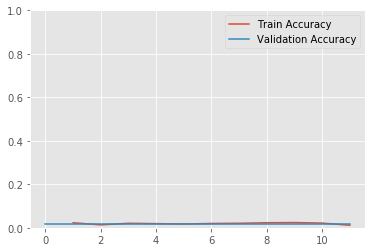

KeyboardInterrupt: 

In [480]:
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        total_loss, len_loss, dig_loss = model.train_on_batch(batch_x, [batch_ylen, batch_y])
        
        ep_len_losses.append(len_loss)
        ep_dig_losses.append(dig_loss)
        if (batch_idx) % compare_every == 0:
            capture_performance2()
                   
    v_len_proba, v_dig_proba = model.predict(valid_x)
    _, v_len_loss, v_dig_loss = model.evaluate(valid_x, [valid_ylen, valid_y])
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

# Improving on Model Architecture

In [24]:
lr = 0.001
len_balance = 0.5  # give the sequence length loss len_balance weight and the sequence digits loss (1-len_balance) weight 
simplest_graph =  tf.Graph()

In [81]:
with simplest_graph.as_default(): 
    tf_x = tf.placeholder(tf.float32, (None, all_x.shape[1], all_x.shape[2], 1))
    tf_y = tf.placeholder(tf.float32, (None, all_y.shape[1], all_y.shape[2]))
    tf_ylen = tf.placeholder(tf.int32, (None, 5))
    
    # (N, 28, 140, 1)
    conv1_w = tf.Variable(tf.truncated_normal(shape=[5, 5, 1, 5], stddev=0.1, seed=54), name="conv1_w")
    conv1_b = tf.Variable(tf.zeros(shape=[5]), name="conv1_b")
    
    # (N, 28, 140, 5)
    conv2_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 5, 5], stddev=0.1, seed=741), name="conv2_w")
    conv2_b = tf.Variable(tf.zeros(shape=[5]), name="conv2_b")
    
    # (N, 28, 140, 5)
    
    
    # (N, 15, 71, 5)
    conv4_w = tf.Variable(tf.truncated_normal(shape=[3, 3, 5, 15], stddev=0.1, seed=11), name="conv4_w")
    conv4_b = tf.Variable(tf.zeros(shape=[15]), name="conv4_b")
    
    # (N, 15, 71, 15)
    conv5_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 15, 7], stddev=0.1, seed=8898), name="conv5_w")
    conv5_b = tf.Variable(tf.zeros(shape=[7]), name="conv5_b")
    
    # (N, 15, 71, 7)
        
    # (N, 8, 36, 7)
    conv7_w = tf.Variable(tf.truncated_normal(shape=[2, 2, 7, 30], stddev=0.1, seed=8751), name="conv7_w")
    conv7_b = tf.Variable(tf.zeros(shape=[30]), name="conv7_b")
    
    # (N, 8, 36, 30)
    conv8_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 30, 15], stddev=0.1, seed=5648), name="conv8_w")
    conv8_b = tf.Variable(tf.zeros(shape=[15]), name="conv8_b")
    
    # (N, 8, 36, 15)
    
    # (N, 4, 18, 15)
    conv10_w = tf.Variable(tf.truncated_normal(shape=[4, 4, 15, 60], stddev=0.1, seed=77777), name="conv10_w")
    conv10_b = tf.Variable(tf.zeros(shape=[60]), name="conv10_b")
    
    # (N, 4, 18, 30)
    conv11_w = tf.Variable(tf.truncated_normal(shape=[1, 1, 60, 60], stddev=0.1, seed=55776), name="conv11_w")
    conv11_b = tf.Variable(tf.zeros(shape=[60]), name="conv11_b")
    
    # (N, 4, 18, 60)
    
    # (N, 2, 9, 60) -> (N, 1080)
    dens13_w = tf.Variable(tf.truncated_normal(shape=[1080, 540], stddev=0.1, seed=258), name="dens13_w")
    dens13_b = tf.Variable(tf.zeros(shape=[540]), name="dens13_b")
    
    # (N, 200)
    len_w = tf.Variable(tf.truncated_normal(shape=[540, 5], stddev=0.1, seed=369), name="len_w")
    len_b = tf.Variable(tf.zeros(shape=[5]), name="len_b")
    
    # (N, 200)
    dig_w = tf.Variable(tf.truncated_normal(shape=[540, 5*10], stddev=0.1, seed=147), name="dig_w")
    dig_b = tf.Variable(tf.zeros(shape=[5*10]), name="dig_b")

In [82]:
def model(x):
    o1 = tf.nn.relu(tf.nn.conv2d(x, conv1_w, [1, 1, 1, 1], 'SAME') + conv1_b)
    o2 = tf.nn.relu(tf.nn.conv2d(o1, conv2_w, [1, 1, 1, 1], 'SAME') + conv2_b)
    o3 = tf.nn.max_pool(o2, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o4 = tf.nn.relu(tf.nn.conv2d(o3, conv4_w, [1, 1, 1, 1], 'SAME') + conv4_b)
    o5 = tf.nn.relu(tf.nn.conv2d(o4, conv5_w, [1, 1, 1, 1], 'SAME') + conv5_b)
    o6 = tf.nn.max_pool(o5, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o7 = tf.nn.relu(tf.nn.conv2d(o6, conv7_w, [1, 1, 1, 1], 'SAME') + conv7_b)
    o8 = tf.nn.relu(tf.nn.conv2d(o7, conv8_w, [1, 1, 1, 1], 'SAME') + conv8_b)
    o9 = tf.nn.max_pool(o8, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME')
    o10 = tf.nn.relu(tf.nn.conv2d(o9, conv10_w, [1, 1, 1, 1], 'SAME') + conv10_b)
    o11 = tf.nn.relu(tf.nn.conv2d(o10, conv11_w, [1, 1, 1, 1], 'SAME') + conv11_b)
    o12 = tf.nn.max_pool(o11, [1, 2, 2, 1], [1, 2, 2, 1], 'SAME') 
        
    o12resh = tf.reshape(o12, [-1, 1080])
    o13 = tf.nn.relu(tf.matmul(o12resh, dens13_w) + dens13_b)
    return o13

In [83]:
with simplest_graph.as_default():
    
    hrep = model(tf_x)
    tf_lenlogit = tf.matmul(hrep, len_w) + len_b
    tf_lenproba = tf.nn.softmax(tf_lenlogit)
    tf_diglogit = tf.reshape(tf.matmul(hrep, dig_w) + dig_b, [-1, 5, 10])
    tf_digproba = tf.nn.softmax(tf_diglogit, dim=-1)
    
    
    tf_len_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_ylen, logits=tf_lenlogit))
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    mask = tf.cast(mask, tf.bool)
#     tf_dig_loss = tf.reduce_mean(
#         tf.nn.softmax_cross_entropy_with_logits(
#             labels=tf.boolean_mask(tf_y, mask),
#             logits=tf.boolean_mask(tf_diglogit, mask)
#         )
#     )
    
    
    cross_entropy = -tf.reduce_sum(tf_y * tf.log(tf_digproba), reduction_indices=2)
    mask = tf.sign(tf.reduce_max(tf.abs(tf_y), reduction_indices=2))
    masked_cross_entropy = cross_entropy * mask
    
    mean_masked_xe = tf.reduce_sum(masked_cross_entropy, reduction_indices=1)
    mean_masked_xe /= tf.reduce_sum(mask, reduction_indices=1)

    tf_dig_loss = tf.reduce_mean(masked_xe(tf_digproba, tf_y))
    
    
    
    optimizer = tf.train.AdamOptimizer(lr)
    updater = optimizer.minimize(tf_len_loss*len_balance + tf_dig_loss*(1-len_balance))

In [84]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 2500
compare_every = 30
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

In [85]:
def capture_performance():
    global session
    global batch_size
    global batch_idx
    global train_x
    global train_y
    global train_ylen
    global valid_x
    global valid_y
    global valid_ylen
    global t_acc
    global v_acc
#     print('Saving performance')
    
    train_len_loss, train_dig_loss, train_len_proba, train_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: train_x[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_y: train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
        tf_ylen: train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)]        
    })
    
    valid_len_loss, valid_dig_loss, valid_len_proba, valid_dig_proba = session.run([tf_len_loss, tf_dig_loss, 
                                                                                    tf_lenproba, tf_digproba], 
                                                                                   feed_dict={
        tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    
    t_len_losses.append(np.mean(train_len_loss))
    t_dig_losses.append(np.mean(train_dig_loss))
    t_acc.append(accuracy(train_y[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)], 
                          train_ylen[batch_size*(batch_idx-compare_every+1):batch_size*(batch_idx+1)],
                          train_dig_proba,
                          train_len_proba))
    v_len_losses.append(np.mean(valid_len_loss))
    v_dig_losses.append(np.mean(valid_dig_loss))
    v_acc.append(accuracy(valid_y, valid_ylen, valid_dig_proba, valid_len_proba))                      

C:\Users\Ian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Epoch 0
Validation accuracy 60.180%
Mean batch len loss 0.052
Valid len loss 0.008
Mean batch dig loss 1.308
Valid dig loss 0.478


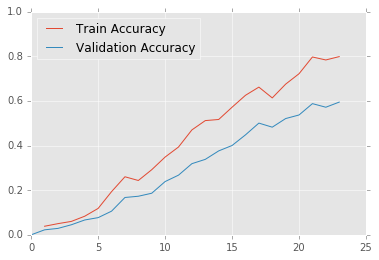

Epoch 1
Validation accuracy 75.589%
Mean batch len loss 0.005
Valid len loss 0.007
Mean batch dig loss 0.323
Valid dig loss 0.281


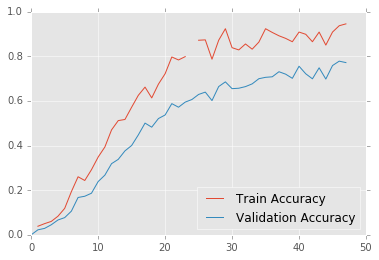

Epoch 2
Validation accuracy 82.083%
Mean batch len loss 0.004
Valid len loss 0.004
Mean batch dig loss 0.175
Valid dig loss 0.200


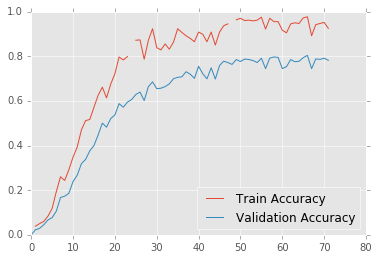

Epoch 3
Validation accuracy 80.411%
Mean batch len loss 0.001
Valid len loss 0.004
Mean batch dig loss 0.111
Valid dig loss 0.230


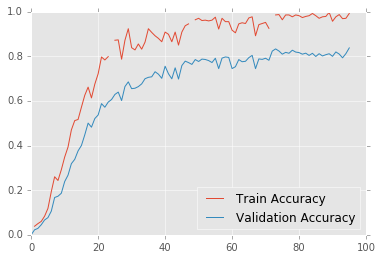

Epoch 4
Validation accuracy 83.605%
Mean batch len loss 0.000
Valid len loss 0.006
Mean batch dig loss 0.079
Valid dig loss 0.203


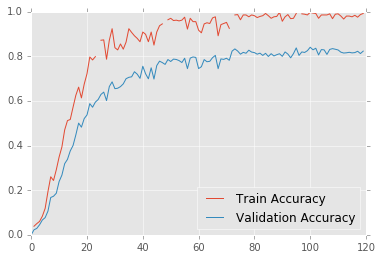

Epoch 5
Validation accuracy 84.698%
Mean batch len loss 0.002
Valid len loss 0.007
Mean batch dig loss 0.067
Valid dig loss 0.188


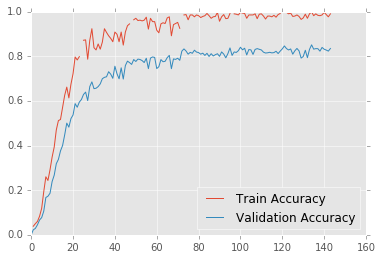

Epoch 6
Validation accuracy 84.848%
Mean batch len loss 0.001
Valid len loss 0.012
Mean batch dig loss 0.054
Valid dig loss 0.194


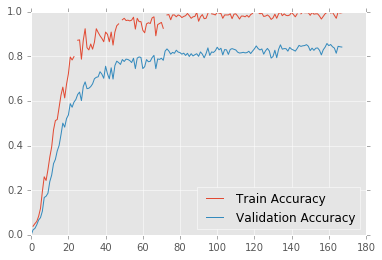

Epoch 7
Validation accuracy 85.426%
Mean batch len loss 0.005
Valid len loss 0.013
Mean batch dig loss 0.049
Valid dig loss 0.176


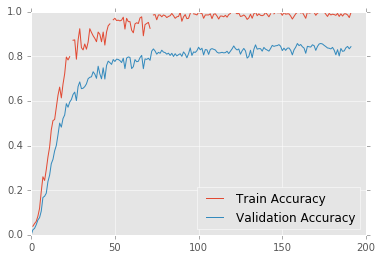

In [ ]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='best')
    plt.show()

C:\Users\Ian\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


Epoch 0
Validation accuracy 64.295%
Mean batch len loss 0.050
Valid len loss 0.006
Mean batch dig loss 1.230
Valid dig loss 0.418


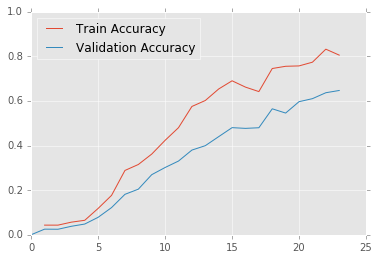

Epoch 1
Validation accuracy 79.919%
Mean batch len loss 0.006
Valid len loss 0.006
Mean batch dig loss 0.271
Valid dig loss 0.223


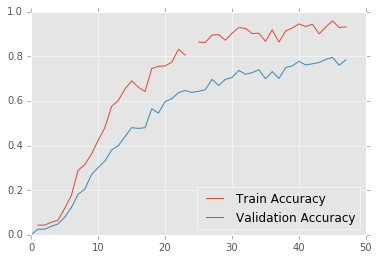

Epoch 2
Validation accuracy 79.747%
Mean batch len loss 0.002
Valid len loss 0.005
Mean batch dig loss 0.148
Valid dig loss 0.225


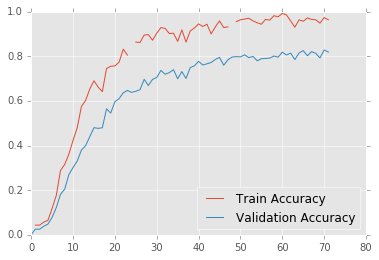

Epoch 3
Validation accuracy 84.719%
Mean batch len loss 0.003
Valid len loss 0.006
Mean batch dig loss 0.101
Valid dig loss 0.179


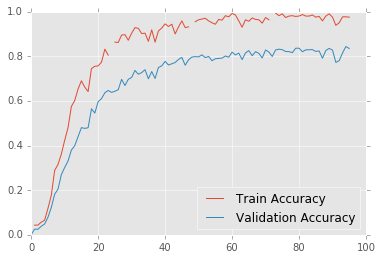

Epoch 4
Validation accuracy 83.240%
Mean batch len loss 0.001
Valid len loss 0.005
Mean batch dig loss 0.072
Valid dig loss 0.207


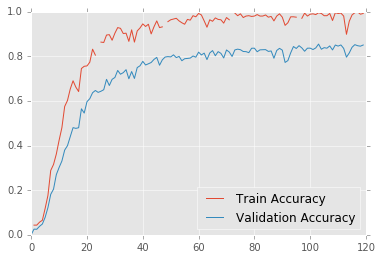

KeyboardInterrupt: 

In [53]:
session = tf.InteractiveSession(graph=simplest_graph)
init = tf.global_variables_initializer()
init.run()
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
#         _,  batch_len_loss, batch_dig_loss, batch_mean_masked_xe, batch_mask, batch_masked_xe, batch_cross_entropy, batch_dig_proba = \
#                 session.run([updater, tf_len_loss, tf_dig_loss, mean_masked_xe, mask, masked_cross_entropy, cross_entropy, tf_digproba], 
#                                                          feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        _,  batch_len_loss, batch_dig_loss = session.run([updater, tf_len_loss, tf_dig_loss], 
                                                         feed_dict={tf_x: batch_x, tf_y: batch_y, tf_ylen: batch_ylen})
        ep_len_losses.append(np.mean(batch_len_loss))
        ep_dig_losses.append(np.mean(batch_dig_loss))
        if (batch_idx) % compare_every == 0:
            capture_performance()        
        
    v_len_loss, v_dig_loss, v_len_proba, v_dig_proba = session.run([tf_len_loss, tf_dig_loss, tf_lenproba, tf_digproba], 
                                                                {tf_x: valid_x, tf_y: valid_y, tf_ylen: valid_ylen})
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend(loc='best')
    plt.show()

In [25]:
in0 = Input(shape=[all_x.shape[1], all_x.shape[2], 1], name='X')
conv1 = Conv2D(5, (3, 3), strides=(1, 1), padding='same', activation='relu')(in0)
conv2 = Conv2D(25, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv1)
conv2 = Conv2D(50, (3, 3), strides=(1, 1), padding='same', activation='relu')(conv2)
max3 = MaxPool2D((2, 2), (2, 2), padding='same')(conv2)
conv4 = Conv2D(100, (3, 3), strides=(1, 1), padding='same', activation='relu')(max3)
conv5 = Conv2D(200, (5, 5), strides=(1, 1), padding='same', activation='relu')(conv4)
max6 = MaxPool2D((2, 2), (2, 2), padding='same')(conv5)
conv7 = Conv2D(200, (3, 3), strides=(1, 1), padding='same', activation='relu')(max6)
conv8 = Conv2D(200, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv7)
max9 = MaxPool2D((2, 2), (2, 2), padding='same')(conv8)
conv10 = Conv2D(100, (5, 5), strides=(1, 1), padding='same', activation='relu')(max9)
conv11 = Conv2D(50, (1, 1), strides=(1, 1), padding='same', activation='relu')(conv10)
max12 = MaxPool2D((2, 2), (2, 2), padding='same')(conv11)

resh12 = Reshape([-1])(max12)
dens13 = Dense(800, activation='relu', kernel_regularizer=l2(0.0001))(resh12)
dens13 = Dropout(0.5)(dens13)
dens14 = Dense(400, activation='relu', kernel_regularizer=l2(0.0001))(dens13)
dens14 = Dropout(0.5)(dens14)

len_15 = Dense(5, activation='softmax', kernel_regularizer=l2(0.0001), name='LEN')(dens14)

dig_15 = Dense(5*10, activation='linear', kernel_regularizer=l2(0.0001))(dens14)
resh15 = Reshape([5, 10])(dig_15)
softmax15 = Activation('softmax')(resh15)

model = Model(in0, outputs=[len_15, softmax15])
opt = Adam(0.001)
model.compile(optimizer=opt, loss=['categorical_crossentropy', tf_masked_xe], loss_weights=[0.5, 0.5])

In [26]:
n_epochs = 30
batch_size = 20
steps_per_epoch = 250000
compare_every = 60
t_len_losses, v_len_losses = [], []
t_dig_losses, v_dig_losses = [], []
t_acc, v_acc = [], []

Epoch 0
Validation accuracy 31.633%
Mean batch len loss 0.103
Valid len loss 0.010
Mean batch dig loss 2.011
Valid dig loss 1.026


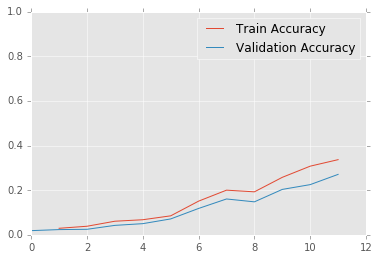

Epoch 1
Validation accuracy 72.718%
Mean batch len loss 0.049
Valid len loss 0.008
Mean batch dig loss 0.836
Valid dig loss 0.311


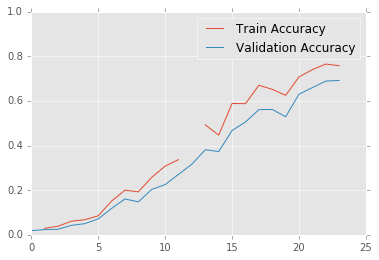

Epoch 2
Validation accuracy 84.291%
Mean batch len loss 0.032
Valid len loss 0.006
Mean batch dig loss 0.446
Valid dig loss 0.175


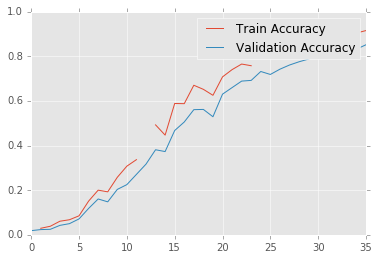

Epoch 3
Validation accuracy 90.291%
Mean batch len loss 0.021
Valid len loss 0.008
Mean batch dig loss 0.307
Valid dig loss 0.107


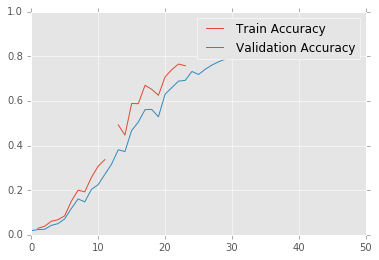

Epoch 4
Validation accuracy 91.985%
Mean batch len loss 0.021
Valid len loss 0.004
Mean batch dig loss 0.240
Valid dig loss 0.097


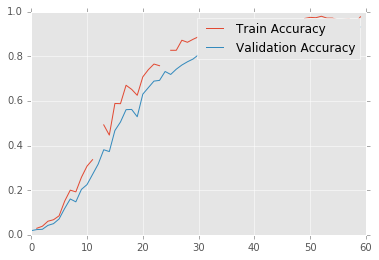

Epoch 5
Validation accuracy 95.392%
Mean batch len loss 0.018
Valid len loss 0.003
Mean batch dig loss 0.197
Valid dig loss 0.071


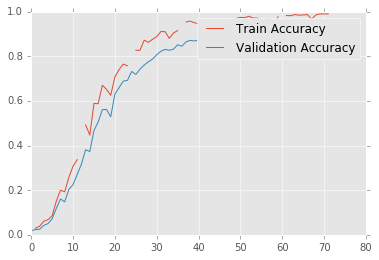

Epoch 6
Validation accuracy 95.456%
Mean batch len loss 0.020
Valid len loss 0.005
Mean batch dig loss 0.180
Valid dig loss 0.070


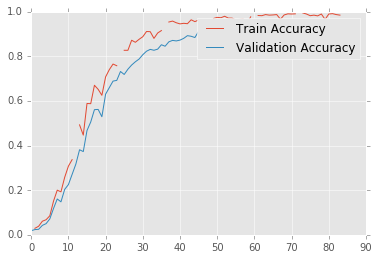

Epoch 7
Validation accuracy 95.542%
Mean batch len loss 0.017
Valid len loss 0.003
Mean batch dig loss 0.168
Valid dig loss 0.062


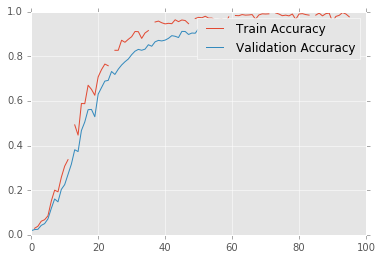

Epoch 8
Validation accuracy 95.585%
Mean batch len loss 0.015
Valid len loss 0.003
Mean batch dig loss 0.142
Valid dig loss 0.063


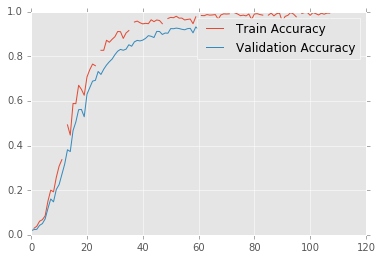

Epoch 9
Validation accuracy 95.199%
Mean batch len loss 0.013
Valid len loss 0.002
Mean batch dig loss 0.143
Valid dig loss 0.077


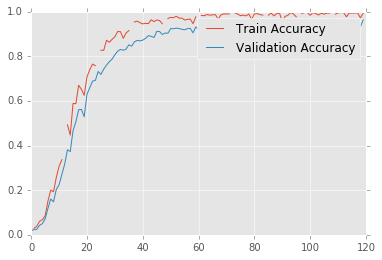

Epoch 10
Validation accuracy 95.092%
Mean batch len loss 0.009
Valid len loss 0.005
Mean batch dig loss 0.131
Valid dig loss 0.068


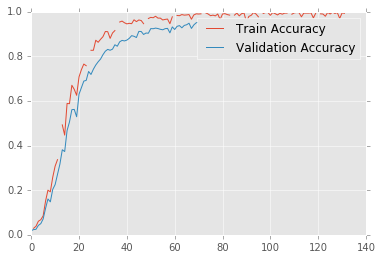

Epoch 11
Validation accuracy 95.928%
Mean batch len loss 0.015
Valid len loss 0.004
Mean batch dig loss 0.133
Valid dig loss 0.059


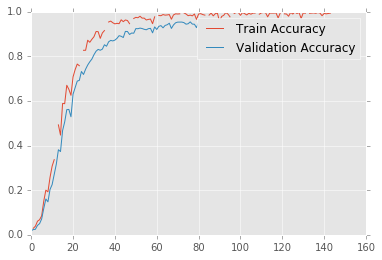

Epoch 12
Validation accuracy 96.228%
Mean batch len loss 0.012
Valid len loss 0.002
Mean batch dig loss 0.123
Valid dig loss 0.058


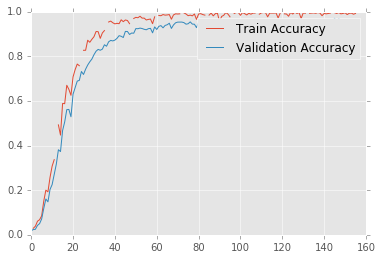

Epoch 13
Validation accuracy 97.021%
Mean batch len loss 0.010
Valid len loss 0.001
Mean batch dig loss 0.113
Valid dig loss 0.050


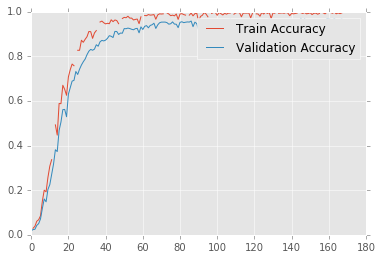

Epoch 14
Validation accuracy 96.207%
Mean batch len loss 0.014
Valid len loss 0.003
Mean batch dig loss 0.121
Valid dig loss 0.061


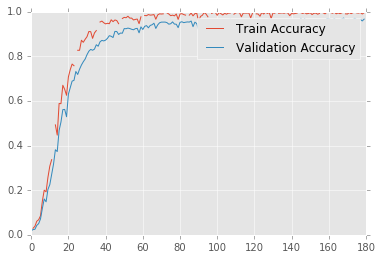

Epoch 15
Validation accuracy 95.564%
Mean batch len loss 0.011
Valid len loss 0.004
Mean batch dig loss 0.103
Valid dig loss 0.073


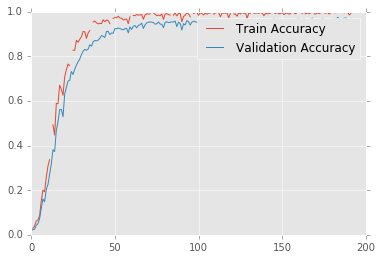

Epoch 16
Validation accuracy 95.456%
Mean batch len loss 0.012
Valid len loss 0.002
Mean batch dig loss 0.117
Valid dig loss 0.078


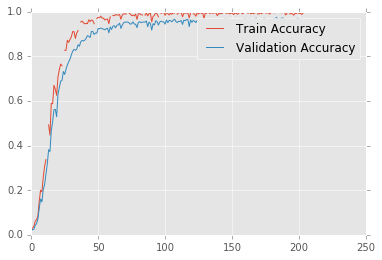

Epoch 17
Validation accuracy 1.650%
Mean batch len loss nan
Valid len loss nan
Mean batch dig loss nan
Valid dig loss nan


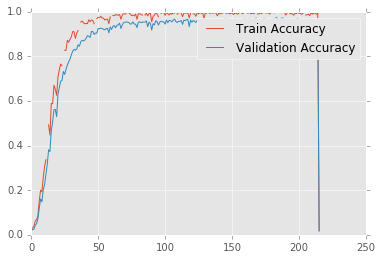

Epoch 18
Validation accuracy 1.650%
Mean batch len loss nan
Valid len loss nan
Mean batch dig loss nan
Valid dig loss nan


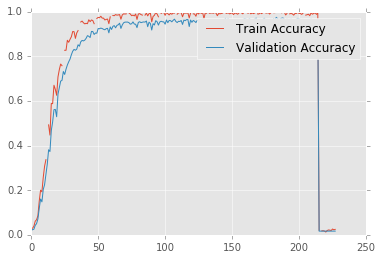

KeyboardInterrupt: 

In [27]:
np.random.seed(123456)
for ep in range(n_epochs):
    idx = np.arange(len(train_x))
    np.random.shuffle(idx) # shuffling the data each epoch
    train_x = train_x[idx]
    train_y = train_y[idx]
    train_ylen = train_ylen[idx]
    ep_len_losses = []
    ep_dig_losses = []
    for batch_idx in range(min(len(train_x)//batch_size, steps_per_epoch)):
        batch_x = train_x[batch_size*batch_idx:(batch_size*(batch_idx+1))].reshape(-1, 28, 140, 1)
        batch_y = train_y[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        batch_ylen = train_ylen[batch_size*batch_idx:(batch_size*(batch_idx+1))]
        total_loss, len_loss, dig_loss = model.train_on_batch(batch_x, [batch_ylen, batch_y])
        
        ep_len_losses.append(len_loss)
        ep_dig_losses.append(dig_loss)
        if (batch_idx) % compare_every == 0:
            capture_performance2()
    capture_performance2()
                   
    v_len_proba, v_dig_proba = model.predict(valid_x)
    _, v_len_loss, v_dig_loss = model.evaluate(valid_x, [valid_ylen, valid_y], verbose=0)
    print("Epoch {}".format(ep))
#     print(v_acc)
    print("Validation accuracy {:<2.3%}".format(accuracy(valid_y, valid_ylen, v_dig_proba, v_len_proba)))
          
    print("Mean batch len loss {:<2.3f}".format(np.mean(ep_len_losses)))
    print("Valid len loss {:<2.3f}".format(np.mean(v_len_loss)))
    
    print("Mean batch dig loss {:<2.3f}".format(np.mean(ep_dig_losses)))
    print("Valid dig loss {:<2.3f}".format(np.mean(v_dig_loss)))
    
    plt.plot(t_acc, label='Train Accuracy')
    plt.plot(v_acc, label='Validation Accuracy')
    plt.ylim((0, 1))
    plt.legend()
    plt.show()

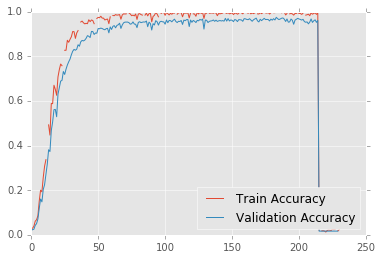

In [28]:
plt.plot(t_acc, label='Train Accuracy')
plt.plot(v_acc, label='Validation Accuracy')
plt.ylim((0, 1))
plt.legend(loc='best')
plt.show()

In [29]:
max(v_acc)

0.97428204029147025

In [30]:
v_acc

[0.018645520788684099,
 0.023360480068581227,
 0.024646378054007715,
 0.042220317188169737,
 0.049935705100728672,
 0.071153021860265758,
 0.11808829832833262,
 0.16052293184740676,
 0.14766395199314189,
 0.20338619802828975,
 0.22481783111873124,
 0.27068152593227601,
 0.31654522074582081,
 0.3810544363480497,
 0.37291041577368195,
 0.46720960137162454,
 0.5053579082726104,
 0.56065152164594945,
 0.56172310330047148,
 0.52893270467209597,
 0.63009001285897981,
 0.6594513501928847,
 0.68859837119588507,
 0.6918131161594514,
 0.73167595370767258,
 0.71838834119159878,
 0.74196313759108445,
 0.76060865837976854,
 0.77518216888126878,
 0.78739819974282044,
 0.80690098585512215,
 0.82254607801114443,
 0.83069009858551224,
 0.8268324046292328,
 0.83176168024003427,
 0.85147878268324051,
 0.84483497642520355,
 0.86455207886840979,
 0.87098156879554223,
 0.86862408915559364,
 0.87226746678096867,
 0.88019717102443207,
 0.89219888555507931,
 0.88941277325332191,
 0.8838405486498071,
 0.9112730

In [33]:
np.median(v_acc[-60:-15])

0.96420917273896267